In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.tsv', sep ='\t')
data

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7390,http://techcrunch.com/2010/09/08/kno-raises-46...,8958,"{""title"":""Kno Raises 46 Million More To Build ...",computer_internet,0.651067,3.010526,0.474747,0.222222,0.191919,0.191919,...,1,1,38,0,2219,99,11,0.040404,0.071429,0
7391,http://www.uncoached.com/category/why-i-miss-c...,8895,"{""title"":""Why I Miss College "",""body"":""Mar 30 ...",culture_politics,0.14192,2.208054,0.483333,0.246667,0.036667,0.026667,...,1,1,34,0,5672,300,4,0.020000,0.109453,0
7392,http://eatthis.menshealth.com/slide/sweet-pota...,1191,"{""title"":""Sweet Potatoes Eat This Not That i'...",recreation,0.196273,2.000000,0.315789,0.171053,0.105263,0.052632,...,?,1,43,0,848,76,5,0.434211,0.117647,1
7393,http://naturallyella.com/,5612,"{""title"":""Naturally Ella "",""body"":"" "",""url"":""n...",arts_entertainment,0.617876,1.026316,0.210526,0.052632,0.000000,0.000000,...,1,0,37,1,386,38,0,0.026316,0.333333,1


In [3]:
def info_columns(data_):
    total_na = data_.isna().sum().sum()
    print("Dimensional:", data_.shape[0], "rows,", data_.shape[1], "columns")
    print("Total NA values: %d" %(total_na))
    print("%38s%10s%10s%10s" %("Column Name", "Data type", "#Distinct", "#NaN"))
    col_name = data_.columns
    dtype = data_.dtypes
    uniq = data_.nunique()
    
    for i in range(len(col_name)):
        print("%38s%10s%10s%10s" %(col_name[i], dtype[i], uniq[i], data_[col_name[i]].isna().sum()))

In [4]:
info_columns(data)

Dimensional: 7395 rows, 27 columns
Total NA values: 0
                           Column Name Data type #Distinct      #NaN
                                   url    object      7395         0
                                 urlid     int64      7395         0
                           boilerplate    object      7394         0
                      alchemy_category    object        14         0
                alchemy_category_score    object      4806         0
                           avglinksize   float64      5710         0
                     commonlinkratio_1   float64      4476         0
                     commonlinkratio_2   float64      4038         0
                     commonlinkratio_3   float64      3266         0
                     commonlinkratio_4   float64      2695         0
                     compression_ratio   float64      6453         0
                           embed_ratio   float64       366         0
                            framebased     int64 

In [5]:
def fill_new_front_page(data_):
    dic = {x: 0 for x in data_['website_type'].values}
    for x in dic.keys():
        if (data_[data_['news_front_page'] == 1]['website_type'].values == x).sum() > (data_[data_['news_front_page'] == 0]['website_type'].values == x).sum():
            dic[x] = 1
        elif (data_[data_['news_front_page'] == 1]['website_type'].values == x).sum() == (data_[data_['news_front_page'] == 0]['website_type'].values == x).sum():
            dic[x] = np.random.randint(2)
        else:
            dic[x] = 0
    
    for i in range(data_.shape[0]):
        if data_[i:i+1]['news_front_page'].values == -1:
            data_[i:i+1]['news_front_page'].replace(-1, dic.get(data_[i:i+1]['website_type'].values[0]), inplace= True)
    
    return data_

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
def new_link_pre(df_train):
    linktrain1 = set(df_train[df_train['label'] == 1]['linkwordscore'].values)
    linktrain0 = set(df_train[df_train['label'] == 0]['linkwordscore'].values)
    link = list(linktrain1.intersection(linktrain0))
    
    val_count1 = []
    val_count0 = []
    for x in link:
        ah = df_train[df_train['linkwordscore'] == x]['label'].value_counts()
        val_count0.append(ah[0])
        val_count1.append(ah[1])
        
    for x in list(linktrain0 - linktrain1):
        link.append(x)
        val_count0.append(df_train[df_train['linkwordscore'] == x]['label'].value_counts()[0])
        val_count1.append(0)
    for x in list(linktrain1 - linktrain0):
        link.append(x)
        val_count1.append(df_train[df_train['linkwordscore'] == x]['label'].value_counts()[1])
        val_count0.append(0)
        
    rel = []
#     ler = []
#     for x in range(len(link)):
#         if val_count0[x] > val_count1[x]:
#             prob_1 = val_count1[x] / (val_count0[x] + val_count1[x]) 
#             rel.append(sigmoid(-prob_1 - 2*(1-prob_1)))
# #             ler.append(0)
            
#         elif val_count0[x] < val_count1[x]:
#             prob_1 = val_count1[x] / (val_count0[x] + val_count1[x]) 
#             rel.append(sigmoid(prob_1*2 + (1-prob_1)))
# #             ler.append(1)
#         else:
#             prob_1 = val_count1[x] / (val_count0[x] + val_count1[x]) 
#             rel.append(sigmoid(prob_1 - (1-prob_1)))
#             ler.append(np.random.randint(2))
    for x in range(len(link)):
        prob_1 = val_count1[x] / (val_count0[x] + val_count1[x])
        if prob_1 <= 0.4:
            rel.append(sigmoid(-prob_1 - 2*(1-prob_1)))
            
        elif prob_1 >= 0.6:
            prob_1 = val_count1[x] / (val_count0[x] + val_count1[x]) 
            rel.append(sigmoid(prob_1*2 + (1-prob_1)))
            
        else:
            prob_1 = val_count1[x] / (val_count0[x] + val_count1[x]) 
#             rel.append(sigmoid(prob_1 - (1-prob_1)))
            rel.append(sigmoid(2*(prob_1 - (1-prob_1))))
    
#     linkpd = pd.DataFrame({'linkscore': link, 'label = 1': val_count1, 'label = 0': val_count0, 'result_prob': rel, 'result_quan': ler})
    linkpd = pd.DataFrame({'linkscore': link, 'label = 1': val_count1, 'label = 0': val_count0, 'result_prob': rel})

    relsprob = []
#     relsquan = []
    for x in df_train['linkwordscore'].values:
        relsprob.append(linkpd[linkpd['linkscore'] == x]['result_prob'].values[0])
#         relsquan.append(linkpd[linkpd['linkscore'] == x]['result_quan'].values[0])
    
#     return relsprob, relsquan
    return relsprob, linkpd

In [8]:
def lld_nol_pre(df_train):
    linktrain1 = set(df_train[df_train['lengthyLinkDomain'] == 1]['numberOfLinks'].values)
    linktrain0 = set(df_train[df_train['lengthyLinkDomain'] == 0]['numberOfLinks'].values)
    link = list(linktrain1.intersection(linktrain0))
    
    val_count1 = []
    val_count0 = []
    for x in link:
        ah = df_train[df_train['numberOfLinks'] == x]['lengthyLinkDomain'].value_counts()
        val_count0.append(ah[0])
        val_count1.append(ah[1])
        
    for x in list(linktrain0 - linktrain1):
        link.append(x)
        val_count0.append(df_train[df_train['numberOfLinks'] == x]['lengthyLinkDomain'].value_counts()[0])
        val_count1.append(0)
    for x in list(linktrain1 - linktrain0):
        link.append(x)
        val_count1.append(df_train[df_train['numberOfLinks'] == x]['lengthyLinkDomain'].value_counts()[1])
        val_count0.append(0)
        
    rel = []
    for x in range(len(link)):
        prob_1 = val_count1[x] / (val_count0[x] + val_count1[x])
        if prob_1 <= 0.4:
            rel.append(sigmoid(-prob_1 - 2*(1-prob_1)))
            
        elif prob_1 >= 0.6:
            prob_1 = val_count1[x] / (val_count0[x] + val_count1[x]) 
            rel.append(sigmoid(prob_1*2 + (1-prob_1)))
            
        else:
            prob_1 = val_count1[x] / (val_count0[x] + val_count1[x]) 
            rel.append(sigmoid(2*(prob_1 - (1-prob_1))))
    
    linkpd = pd.DataFrame({'numberOfLinks': link, 'lengthyLinkDomain = 1': val_count1, 'lengthyLinkDomain = 0': val_count0, 'result_prob': rel})

    relsprob = []
    for x in df_train['numberOfLinks'].values:
        relsprob.append(linkpd[linkpd['numberOfLinks'] == x]['result_prob'].values[0])
    
    return relsprob

In [11]:
def featurizes(data_):
    text = data_['url'].str.split('//',n = -1, expand = True)[1]

    text2 = []
    text3 = []
    for x in text:
        spli = x.split('/')
        text2.append(spli[0])
        text3.append(x.split(spli[0] + '/')[1])

    subdomain = []
    webname = []
    domain = []
    for x in text2:
        spli = x.split('.')
        if len(spli) == 2:
            subdomain.append('')
            webname.append(spli[0])
            domain.append(spli[1])
        if len(spli) == 3:
            subdomain.append(spli[0])
            webname.append(spli[1])
            domain.append(spli[2])
        if len(spli) == 4:
            subdomain.append(spli[0])
            webname.append(spli[1])
            domain.append(spli[2] + '.' + spli[3])    
        if len(spli) > 4:
            subdomain.append(spli[0])
            webname.append(spli[1])
            domain.append(spli[2] + '.' + spli[3] + '.' + spli[4])

    text4 = []
    text5 = []
    for x in text3:
        spli = x.split('/')
        if len(spli) == 1:
            text4.append(spli[0])
            text5.append('')
        else:
            text4.append(spli[0])
            text5.append(spli[1])   

    punctuation = ['.', '?', '!', '=', '-', '_', '%', ':']
    for i in range(len(text4)):
        for j in punctuation:
            text4[i] = text4[i].replace(j, ' ')
            text5[i] = text5[i].replace(j, ' ')

    website_type = []
    website_type2 = [-1 for i in range(len(text5))]
    for i, x in enumerate(text4):
        spli = x.split(' ')
        if len(spli) == 1:
            website_type.append(spli[0])
        else:
            website_type.append(spli[0])
            website_type2[i] = spli[1]

    for i, x in enumerate(text5):
        if x == '':
            website_type2[i] = ''
        if website_type2[i] == -1:
            website_type2[i] = x.split(' ')[0]  
    
#     rels_prob, rels_quan = new_link_pre(data_)
    
    # Features from URL
    data_['subdomain'] = subdomain
    data_['webname'] = webname
    data_['domain'] = domain
    data_['website_type'] = website_type
    data_['website_type'] = data_['website_type'].replace({'2006':'YEAR', '2007':'YEAR', '2008':'YEAR', 
                              '2009':'YEAR', '2010':'YEAR',
                             '2011':'YEAR', '2012':'YEAR',
                             '2013':'YEAR'})
    
    data_['website_type2'] = website_type2
    data_['website_type2'] = data_['website_type2'].replace({'2006':'YEAR', '2007':'YEAR', '2008':'YEAR', 
                              '2009':'YEAR', '2010':'YEAR',
                             '2011':'YEAR', '2012':'YEAR',
                             '2013':'YEAR'})
    
#     rels_prob = new_link_pre(data_)
#     data_['linkscorepredprob'] = rels_prob
#     data_['linkscorepredquan'] = rels_quan

    data_['wordInHLT'] = data_['non_markup_alphanum_characters'] * data_['linkwordscore'] / 100
    data_['wordError'] = data_['non_markup_alphanum_characters'] * data_['spelling_errors_ratio']
    
    lld = lld_nol_pre(data_)
    data_['lld_nol_prob'] = lld
    
    # Other Features
    data_['alchemy_category_score'] = pd.to_numeric(data_['alchemy_category_score'], errors= 'coerce')
    data_['alchemy_category_score'].fillna(data_['alchemy_category_score'].mean(), inplace= True)
    
#     data_['is_news'] = pd.to_numeric(data_['is_news'], errors= 'coerce')
#     data_['is_news'].fillna(0, inplace= True)
    
    data_['news_front_page'] = pd.to_numeric(data_['news_front_page'], errors= 'coerce')
    data_['news_front_page'].fillna(-1, inplace= True)
    
    data_.drop(columns= ['framebased','url', 'urlid', 'boilerplate', 'is_news'], inplace= True)
    
    # Encoder
    le = LabelEncoder()
    fea = ['alchemy_category', 'subdomain', 'webname', 'domain', 'website_type', 'website_type2']
    for x in fea:
        le.fit(data_[x])
        data_[x] = le.transform(data_[x])
    
    data_ = fill_new_front_page(data_)
    return data_

In [9]:
def fea_importance(new_data, model):
    tes = new_data.columns.tolist()
    tes.remove("label")
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["Feature"] = tes
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:5000].index)

    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(12,8))
    sns.barplot(x="importance",
                y="Feature",
                data=best_features.sort_values(by="importance",
                                                ascending=False))
    plt.title(model)
    plt.tight_layout()
    plt.show()


    imp = best_features.groupby('Feature')['importance'].median().sort_values(ascending=False)

In [12]:
new_data = data.copy()
new_data = featurizes(new_data)

In [13]:
info_columns(new_data)

Dimensional: 7395 rows, 30 columns
Total NA values: 0
                           Column Name Data type #Distinct      #NaN
                      alchemy_category     int64        14         0
                alchemy_category_score   float64      4806         0
                           avglinksize   float64      5710         0
                     commonlinkratio_1   float64      4476         0
                     commonlinkratio_2   float64      4038         0
                     commonlinkratio_3   float64      3266         0
                     commonlinkratio_4   float64      2695         0
                     compression_ratio   float64      6453         0
                           embed_ratio   float64       366         0
                         frameTagRatio   float64      5911         0
                         hasDomainLink     int64         2         0
                            html_ratio   float64      7376         0
                           image_ratio   float64 

In [14]:
rels_prob, linkpd = new_link_pre(new_data)
new_data['linkscorepredprob'] = rels_prob

In [15]:
info_columns(new_data)

Dimensional: 7395 rows, 31 columns
Total NA values: 0
                           Column Name Data type #Distinct      #NaN
                      alchemy_category     int64        14         0
                alchemy_category_score   float64      4806         0
                           avglinksize   float64      5710         0
                     commonlinkratio_1   float64      4476         0
                     commonlinkratio_2   float64      4038         0
                     commonlinkratio_3   float64      3266         0
                     commonlinkratio_4   float64      2695         0
                     compression_ratio   float64      6453         0
                           embed_ratio   float64       366         0
                         frameTagRatio   float64      5911         0
                         hasDomainLink     int64         2         0
                            html_ratio   float64      7376         0
                           image_ratio   float64 

In [18]:
yt = new_data[['label']].values
Xt = new_data[[x for x in new_data.columns if x != 'label']].values
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.2, random_state=102)

print('Training set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Training set: (5916, 30) (5916, 1)
Test set: (1479, 30) (1479, 1)


In [19]:
base_classifiers = [
                    ('Random Forest', RandomForestClassifier(n_estimators=1000, n_jobs= 4, min_samples_leaf= 2, bootstrap= True, min_samples_split= 5, max_features= .1, max_samples= 30)),
                    ('AdaBoost Classifier', AdaBoostClassifier()),
                    ('Gradient Boosting Classifier', GradientBoostingClassifier(n_estimators= 300, learning_rate= 0.08, max_features= 4, min_samples_leaf= 2, min_samples_split= 5, max_depth= 7)),
                    ('Extra Trees Classifier', ExtraTreesClassifier()),
                    ('LightGBM', LGBMClassifier(n_estimators= 300, learning_rate= 0.08, num_leaves= 50,boosting_type= 'gbdt', objective= 'binary', sub_feature= 0.5, max_depth= 7)),
                    ('XGBM', XGBClassifier())]

# ('KNN', KNeighborsClassifier()),
# ('Naive Bayes', GaussianNB()),
# ('Decision Tree', DecisionTreeClassifier()),

In [20]:
pred_prob = []

for x in range(3):
    clf = StackingClassifier(estimators= base_classifiers, final_estimator= LogisticRegression())
    clf.fit(X_train, y_train)
    pred_prob.append(clf.predict_proba(X_test)[:, 1])

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[20:51:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[20:52:06] WARNING: ../src/learner.cc:1061:

In [21]:
def voting_prob(lis):
    return np.mean(lis)

In [22]:
lis = [[] for i in range(y_test.shape[0])]
for i in range(y_test.shape[0]):
    for j in range(len(pred_prob)):
            lis[i].append(pred_prob[j][i])
            
rel = []
for i in range(y_test.shape[0]):
    rel.append(voting_prob(lis[i]))
    
print("Roc_auc_accu", roc_auc_score(y_test, rel) * 100)

Roc_auc_accu 79.1574624027152


Roc_auc_accu RandomForestClassifier(max_features=0.1, max_samples=30, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000, n_jobs=4) 0.7019418558721985


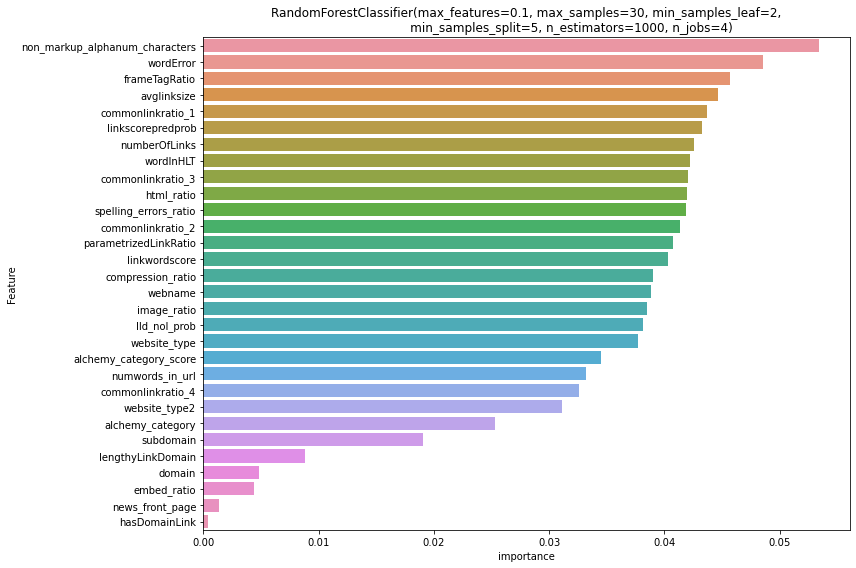

Roc_auc_accu AdaBoostClassifier() 0.7422547033179239


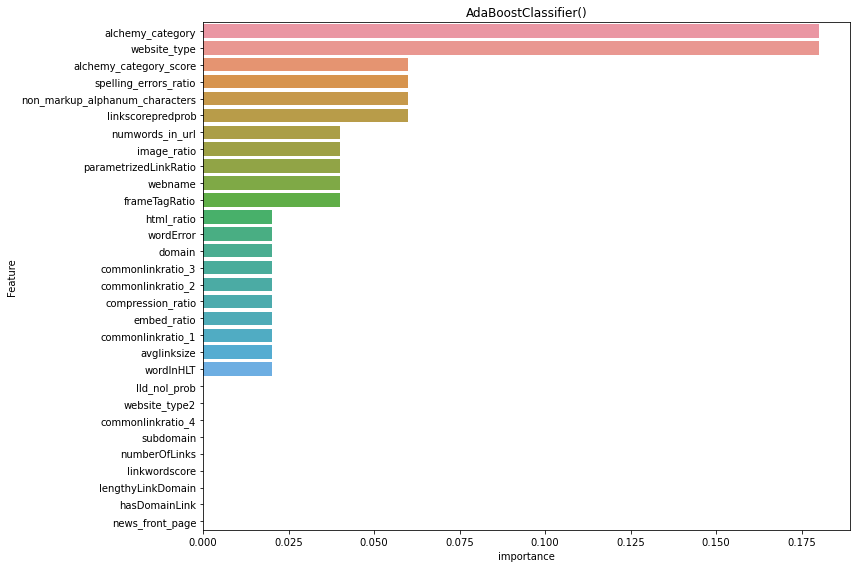

Roc_auc_accu GradientBoostingClassifier(learning_rate=0.08, max_depth=7, max_features=4,
                           min_samples_leaf=2, min_samples_split=5,
                           n_estimators=300) 0.7761791210720346


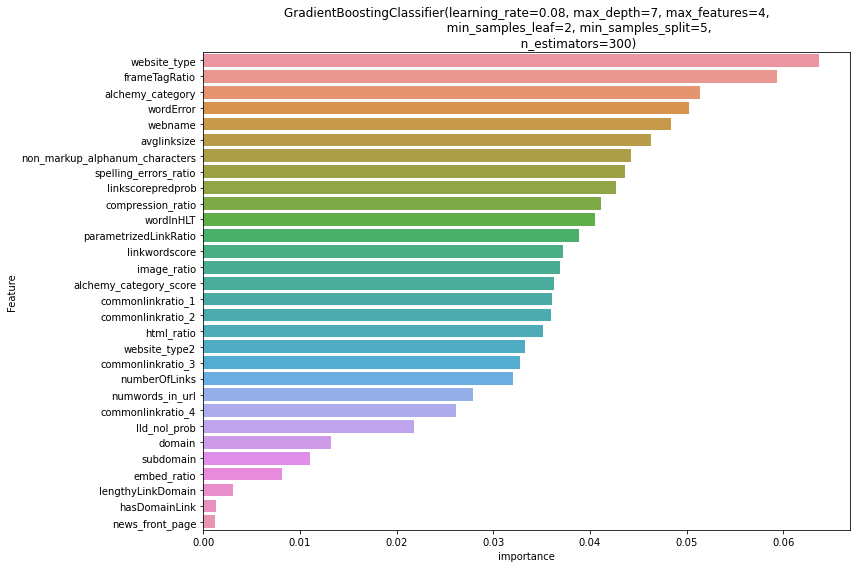

Roc_auc_accu ExtraTreesClassifier() 0.7782043639183099


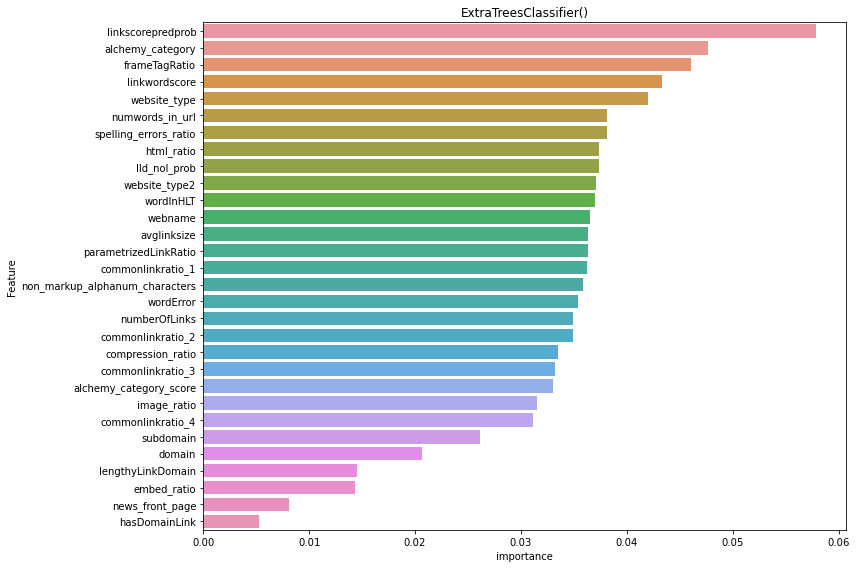

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Roc_auc_accu LGBMClassifier(learning_rate=0.08, max_depth=7, n_estimators=300, num_leaves=50,
               objective='binary', sub_feature=0.5) 0.7850170431271579


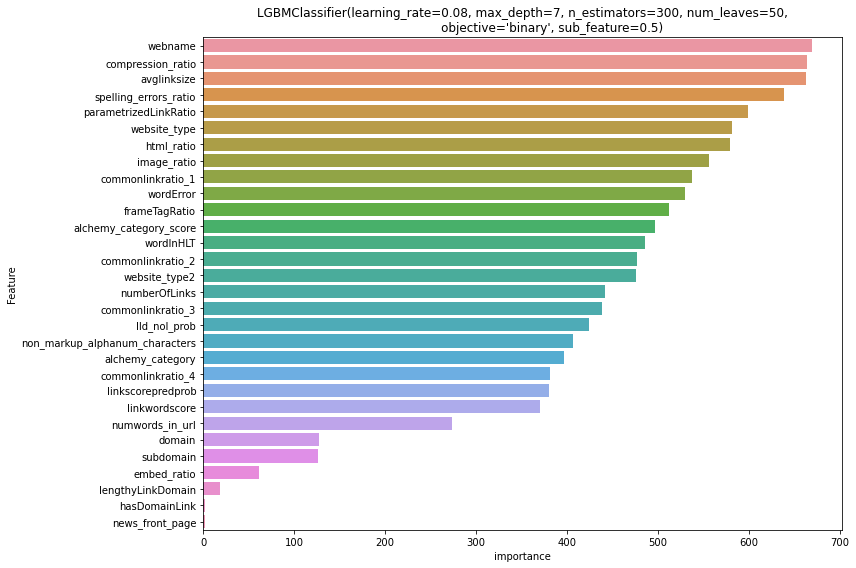

[20:54:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Roc_auc_accu XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 0.7768913848089414


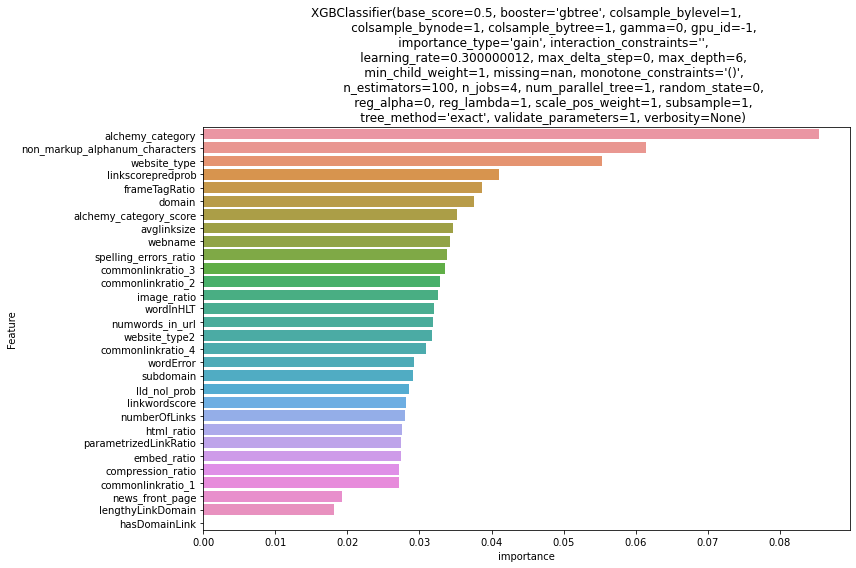

In [23]:
for model in base_classifiers:
    mod = model[1]
    mod.fit(X_train, y_train)
    print("Roc_auc_accu", model[1], roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1]*100))
    fea_importance(new_data, mod)

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Roc_auc_accu XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 0.7850170431271579


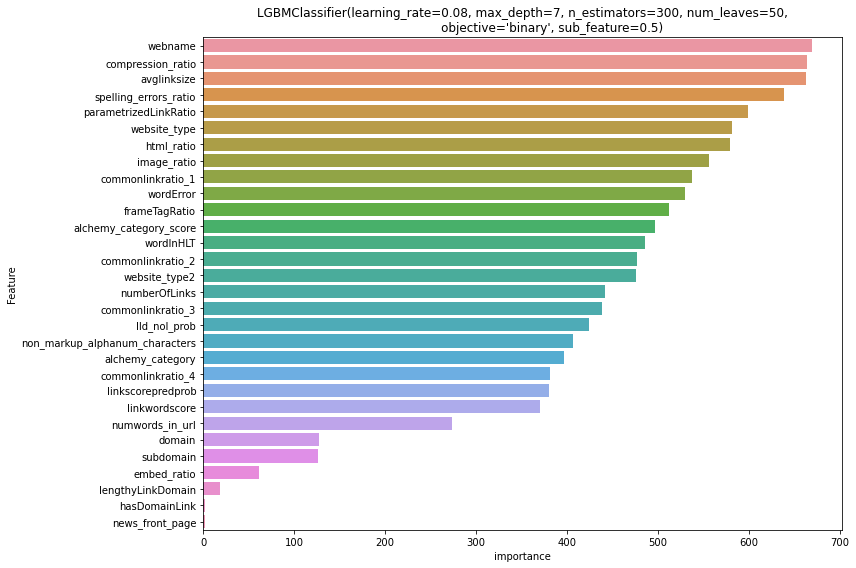

In [24]:
mod = LGBMClassifier(n_estimators= 300, learning_rate= 0.08, num_leaves= 50,boosting_type= 'gbdt', objective= 'binary', sub_feature= 0.5, max_depth= 7)
mod.fit(X_train, y_train)
print("Roc_auc_accu", model[1], roc_auc_score(y_test, mod.predict_proba(X_test)[:, 1]*100))
fea_importance(new_data, mod)

In [146]:
new_data['hasDomainLink'].value_counts()

0    7238
1     157
Name: hasDomainLink, dtype: int64

In [147]:
new_data['news_front_page'].value_counts()

0.0    6895
1.0     500
Name: news_front_page, dtype: int64

In [157]:
he = new_data['embed_ratio'].astype('category')

In [24]:
categorical = [var for var in new_data.columns if new_data[var].dtype == 'object']
for var in categorical:
    print("=============", var, "=============", end='\n\n')
    print(new_data[var].value_counts(), end= '\n\n')

In [163]:
new_data['lengthyLinkDomain'].value_counts()

1    4883
0    2512
Name: lengthyLinkDomain, dtype: int64

In [43]:
data_test = pd.read_csv('test.tsv', sep ='\t')

In [45]:
new_data_test = data_test.copy()
new_data_test = featurizes(new_data_test)

In [46]:
new_data_test

,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,frameTagRatio,...,parametrizedLinkRatio,spelling_errors_ratio,subdomain,webname,domain,website_type,website_type2,wordInHLT,wordError,lld_nol_prob
0,8,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,0.489572,0.0,0.067143,...,0.242647,0.080597,183,872,11,157,6,846.45,454.808956,0.845535
1,4,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,0.782051,0.0,0.042857,...,0.128205,0.176471,0,855,44,20,0,236.84,67.411765,0.538386
2,0,0.594819,2.269565,0.495726,0.384615,0.170940,0.170940,1.250000,0.0,0.058824,...,0.581197,0.125000,183,1640,11,871,0,1016.40,302.500000,0.848415
3,4,0.902590,2.523490,0.705502,0.346278,0.122977,0.090615,0.449366,0.0,0.058081,...,0.038835,0.063126,183,187,11,629,284,2279.19,350.918840,0.880797
4,10,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,0.453757,0.0,0.093023,...,0.096774,0.065341,183,1617,11,438,284,751.06,144.338068,0.867036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,0,0.594819,1.666667,0.376623,0.129870,0.116883,0.090909,0.451883,0.0,0.053763,...,0.012987,0.063401,0,219,11,157,4,443.52,175.746397,0.500000
3167,0,0.594819,1.305556,0.654321,0.123457,0.024691,0.000000,0.479177,0.0,0.019784,...,0.333333,0.061995,183,227,11,376,360,363.48,375.563341,0.466716
3168,0,0.594819,0.717277,0.291667,0.182292,0.000000,0.000000,0.598441,0.0,0.027642,...,0.177083,0.117647,183,1374,11,696,838,546.44,338.352942,0.582570
3169,11,0.424304,0.940000,0.183333,0.066667,0.016667,0.016667,0.359847,0.0,0.071869,...,0.333333,0.111966,0,832,11,81,526,630.87,2354.525002,0.880797


In [66]:
linkpd

,linkscore,label = 1,label = 0,result_prob
0,0,18,30,0.164516
1,1,18,9,0.841131
2,2,23,26,0.469426
3,3,53,36,0.594361
4,4,65,41,0.833856
...,...,...,...,...
96,98,1,2,0.158869
97,99,2,1,0.841131
98,100,3,8,0.150937
99,97,0,3,0.119203


In [69]:
for x in new_data_test['linkwordscore'].values:
    if x not in new_data['linkwordscore'].values:
        print(x)

In [65]:
new_data_test['numberOfLinks'].value_counts()

37      33
121     31
142     27
25      23
123     22
        ..
684      1
690      1
730      1
806      1
1275     1
Name: numberOfLinks, Length: 535, dtype: int64

In [73]:
prob = []
for x in new_data_test['linkwordscore'].values:
    prob.append(linkpd[linkpd['linkscore'] == x]['result_prob'].values[0])

In [75]:
new_data_test['linkscorepredprob'] = prob

In [76]:
info_columns(new_data_test)

Dimensional: 3171 rows, 30 columns
Total NA values: 0
                           Column Name Data type #Distinct      #NaN
                      alchemy_category     int64        12         0
                alchemy_category_score   float64      2036         0
                           avglinksize   float64      2656         0
                     commonlinkratio_1   float64      2228         0
                     commonlinkratio_2   float64      2040         0
                     commonlinkratio_3   float64      1725         0
                     commonlinkratio_4   float64      1381         0
                     compression_ratio   float64      2798         0
                           embed_ratio   float64       172         0
                         frameTagRatio   float64      2784         0
                         hasDomainLink     int64         2         0
                            html_ratio   float64      3165         0
                           image_ratio   float64 

In [78]:
test = new_data_test[[x for x in new_data_test.columns]].values
test.shape

(3171, 30)

In [87]:
pred_prob = []
for x in range(5):
    clf = StackingClassifier(estimators= base_classifiers, final_estimator= LogisticRegression())
    clf.fit(Xt, yt)
    pred_prob.append(clf.predict_proba(test)[:, 1])

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[15:57:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[15:57:40] WARNING: ../src/learner.cc:1061:

[16:00:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[16:00:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored

[16:03:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:03:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:04:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[16:07:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:07:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, th

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[16:10:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[16:10:51] WARNING: ../src/learner.cc:1061:

[16:13:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[16:13:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored

[16:17:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[16:20:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:20:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, th

In [80]:
pred_prob

[array([0.7308227 , 0.18099726, 0.20770402, ..., 0.64331021, 0.21920833,
        0.60935492]),
 array([0.76752392, 0.16462896, 0.20345686, ..., 0.61356341, 0.27014187,
        0.60735426]),
 array([0.76439903, 0.17000867, 0.19087832, ..., 0.60790888, 0.26857179,
        0.6275198 ]),
 array([0.7790162 , 0.17069011, 0.17623987, ..., 0.59877853, 0.24935701,
        0.5475652 ]),
 array([0.76785705, 0.17273637, 0.20477372, ..., 0.58246797, 0.2428286 ,
        0.5888421 ]),
 array([0.7887265 , 0.16632483, 0.21060881, ..., 0.63482359, 0.28897165,
        0.62660675]),
 array([0.77472734, 0.1764395 , 0.18493604, ..., 0.62003976, 0.27047693,
        0.56792523]),
 array([0.71966015, 0.19353332, 0.21005382, ..., 0.56320278, 0.33648169,
        0.63771674]),
 array([0.79084744, 0.17799918, 0.20550293, ..., 0.55062912, 0.23970732,
        0.637379  ]),
 array([0.77741731, 0.18045886, 0.22314224, ..., 0.59897044, 0.25350369,
        0.61967294])]

In [88]:
lis = [[] for i in range(test.shape[0])]
for i in range(test.shape[0]):
    for j in range(len(pred_prob)):
            lis[i].append(pred_prob[j][i])
            
rel = []
for i in range(test.shape[0]):
    rel.append(voting_prob(lis[i]))

In [89]:
xx = pd.DataFrame({'urlid': data_test['urlid'],'label': rel})

In [90]:
compression_opts = dict(method='zip',
                        archive_name='out123.csv')  
xx.to_csv('he.zip', index=False,
          compression=compression_opts)  

In [71]:
new_data_test.describe().T

,count,mean,std,min,25%,50%,75%,max
alchemy_category_score,3171.0,0.594819,0.179060,0.070833,0.533177,0.594819,0.693036,0.999812
avglinksize,3171.0,2.968182,19.536725,0.000000,1.610350,2.065476,2.576541,1062.000000
commonlinkratio_1,3171.0,0.467111,0.199111,0.000000,0.339454,0.478261,0.611270,1.000000
commonlinkratio_2,3171.0,0.207704,0.144784,0.000000,0.100000,0.191919,0.293978,0.857143
commonlinkratio_3,3171.0,0.089960,0.094182,0.000000,0.019608,0.064935,0.131962,0.734932
commonlinkratio_4,3171.0,0.047845,0.071556,0.000000,0.000000,0.019685,0.062794,0.696802
compression_ratio,3171.0,2.375620,5.879138,0.000000,0.441972,0.481728,0.586843,21.000000
embed_ratio,3171.0,-0.106485,0.311377,-1.000000,0.000000,0.000000,0.000000,0.928571
frameTagRatio,3171.0,0.058089,0.043265,0.000000,0.028866,0.048302,0.074899,0.375000
hasDomainLink,3171.0,0.022390,0.147973,0.000000,0.000000,0.000000,0.000000,1.000000


In [72]:
new_data.describe().T

,count,mean,std,min,25%,50%,75%,max
alchemy_category_score,7395.0,0.603334,0.175952,0.070833,0.538758,0.603334,0.708279,0.999426
avglinksize,7395.0,2.761823,8.619793,0.000000,1.602062,2.088235,2.627451,363.000000
commonlinkratio_1,7395.0,0.468230,0.203133,0.000000,0.340370,0.481481,0.616604,1.000000
commonlinkratio_2,7395.0,0.214080,0.146743,0.000000,0.105263,0.202454,0.300000,1.000000
commonlinkratio_3,7395.0,0.092062,0.095978,0.000000,0.022222,0.068627,0.133333,0.980392
commonlinkratio_4,7395.0,0.049262,0.072629,0.000000,0.000000,0.022222,0.065065,0.980392
compression_ratio,7395.0,2.255103,5.704313,0.000000,0.442616,0.483680,0.578227,21.000000
embed_ratio,7395.0,-0.103750,0.306545,-1.000000,0.000000,0.000000,0.000000,0.250000
frameTagRatio,7395.0,0.056423,0.041446,0.000000,0.028502,0.045775,0.073459,0.444444
hasDomainLink,7395.0,0.021231,0.144162,0.000000,0.000000,0.000000,0.000000,1.000000


In [97]:
# categorical = [var for var in new_data_test.columns if new_data_test[var].dtype == 'int']
# for var in categorical:
#     print("=============", var, "=============", end='\n\n')
#     print(new_data_test[var].value_counts(), end= '\n\n')

In [77]:
new_data_test['webname'].value_counts()[new_data_test['webname'].value_counts() > 0].index

Index(['sportsillustrated', 'insidershealth', 'youtube', 'allrecipes',
       'bleacherreport', 'blogs', 'huffingtonpost', 'ivillage', 'epicurious',
       'marthastewart',
       ...
       'fotografiedemoda', 'dailygifblog', 'icantseeyou', 'collegegloss',
       'ztastylife', 'saveur', 'hotpolkadot', 'happyherbivore', 'factcheck',
       'hautemacabre'],
      dtype='object', length=1759)

In [167]:
S1 = set(new_data_test['webname'].value_counts()[new_data_test['webname'].value_counts() > 0].index)
print(S1)
S2 = set(new_data['webname'].value_counts().index)
print(S2)
S1 = S2.intersection(S1)
print(S1)
S2t = set(new_data_test['webname'].value_counts().index)
print(S2t)
S3 = S1 - S2
print(S3)

S4 = list(S2-S1)
S5 = list(S2t-S1)
len(S3)
new_data['webname'] = new_data['webname'].replace(S4, 'random')
new_data_test['webname'] = new_data_test['webname'].replace(S5, 'random')

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
S1, S2, S

In [168]:
categorical = [var for var in new_data.columns if new_data[var].dtype == 'object']
for var in categorical:
    print("=============", var, "=============", end='\n\n')
    print(new_data[var].value_counts(), end= '\n\n')

============= webname =============

random    2984
1284       143
478        126
319         99
1206        99
          ... 
1035         1
1036         1
1037         1
1040         1
0            1
Name: webname, Length: 1666, dtype: int64



In [54]:
# sns.pairplot(data, hue= 'label')

In [55]:
# correlation = data.corr()
# fig, ax = plt.subplots(figsize=(32,32))         # Sample figsize in inches
# sns.heatmap(
#     correlation, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True,
#     ax=ax,
#     annot=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

In [15]:
# data_test = pd.read_csv('test.tsv', sep ='\t')
# data_test

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,"{""title"":""Homemade Enchilada Sauce Lynn s Kitc...",recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,...,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597
1,http://lolpics.se/18552-stun-grenade-ar,782,"{""title"":""lolpics Stun grenade ar "",""body"":"" f...",culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,...,0.080000,?,1,62,0,382,39,2,0.128205,0.176471
2,http://www.xcelerationfitness.com/treadmills.html,6962,"{""title"":""Treadmills "",""body"":"" treadmills, st...",?,?,2.269565,0.495726,0.384615,0.170940,0.170940,...,10.000000,?,1,42,0,2420,117,1,0.581197,0.125000
3,http://www.bloomberg.com/news/2012-02-06/syria...,7640,"{""title"":""Father s Tactics Used by Assad to Cr...",culture_politics,0.90259,2.523490,0.705502,0.346278,0.122977,0.090615,...,0.005964,1,1,41,0,5559,309,10,0.038835,0.063126
4,http://www.wired.com/gadgetlab/2011/12/stem-tu...,3589,"{""title"":""Stem Turns Lemons and Limes Into Jui...",science_technology,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,...,0.035714,1,0,34,0,2209,155,10,0.096774,0.065341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,http://busy-mommy.com/2012/02/peep-brownie-smo...,7264,"{""title"":""Peep Brownie S mores Busy Mommy An I...",?,?,1.666667,0.376623,0.129870,0.116883,0.090909,...,0.075630,1,0,16,0,2772,77,3,0.012987,0.063401
3167,http://www.cannabissearch.com/edibles/cheesecake/,9714,"{""url"":""cannabissearch edibles cheesecake"",""ti...",?,?,1.305556,0.654321,0.123457,0.024691,0.000000,...,0.284153,1,0,6,0,6058,81,2,0.333333,0.061995
3168,http://www.tastespotting.com/popular/views/all...,5903,"{""title"":""Most Viewed Submissions All Time mos...",?,?,0.717277,0.291667,0.182292,0.000000,0.000000,...,0.500000,1,0,19,0,2876,192,4,0.177083,0.117647
3169,http://lifehacker.com/5839197/how-to-get-a-ful...,3176,"{""title"":""How to Get a Complete Workout with N...",sports,0.424304,0.940000,0.183333,0.066667,0.016667,0.016667,...,0.014502,1,1,3,0,21029,180,12,0.333333,0.111966
